In [11]:
from pathlib import Path
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne import io
from mne import Epochs
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter
import torch

In [2]:
import torch
print(torch.__version__)
print("MPS available?", torch.backends.mps.is_available())

2.7.1
MPS available? True


### Config — paths & processing constants  

All hard-coded parameters live in one place so you (or a colleague) can
re-run the notebook on another machine by editing a single cell.

* **paths** – BIDS root and sub-folders inside `derivatives/`
* **data**  – recording constants reused later (montage, sfreq, etc.)

In [3]:
CONFIG = dict(
    paths = dict(
        bids_root   = Path("../bids_dataset"),
        annot_dir   = Path("../bids_dataset/derivatives/annotated"),
        deep_dir    = Path("../bids_dataset/derivatives/deep"),
        timing_csv  = Path("../audio-timeline.csv"),
    ),
    data = dict(
        sfreq       = 125.0,                      # Hz
        eeg_ch      = ["Fp1","Fp2","C3","C4","T7","T8",
                       "O1","O2","F3","F4","Fz","Pz","P3","P4"],
        n_blocks    = 20,
    ),
    model = dict(
        cv_folds    = 5,            # number of StratifiedGroupKFold splits
    ),
)

# create necessary directories
for path in CONFIG["paths"].values():
    if path.suffix == "":  # skip CSV
        path.mkdir(parents=True, exist_ok=True)

print("Notebook-06 CONFIG defined and directories created 🚀")

Notebook-06 CONFIG defined and directories created 🚀


In [4]:
raws = {}
for block_id in range(CONFIG['data']['n_blocks']):
    fname = CONFIG['paths']['annot_dir'] / f'blk{block_id:02d}_annot_raw.fif'
    raws[block_id] = io.read_raw_fif(fname, preload=True)
    print(f"Loaded block {block_id:02d}: {len(raws[block_id].ch_names)} ch, {raws[block_id].times[-1]:.2f}s")

# Quick check: ensure we have all blocks
assert len(raws) == CONFIG['data']['n_blocks'], "Mismatch in number of blocks loaded"

Opening raw data file ../bids_dataset/derivatives/annotated/blk00_annot_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17205 =      7.000 ...   137.640 secs
Ready.
Reading 0 ... 16330  =      0.000 ...   130.640 secs...
Loaded block 00: 15 ch, 130.64s
Opening raw data file ../bids_dataset/derivatives/annotated/blk01_annot_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17427 =      7.000 ...   139.416 secs
Ready.
Reading 0 ... 16552  =      0.000 ...   132.416 secs...
Loaded block 01: 15 ch, 132.42s
Opening raw data file ../bids_dataset/derivatives/annotated/blk02_annot_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 14) active
    Range : 875 ... 17427 =      7.000 ...   139.416 secs
Ready.
Reading 0 ... 16552  =      0.000 ...   132.416 secs...
Loaded block 02: 15 ch, 132.42s
Opening raw data file ../bids_data

## 1. Dataset Structure

In this section, we load all annotated FIF blocks and extract non-overlapping 2 s epochs around each phrase marker, skipping any BAD_intro intervals. We verify:

That all blocks (0–19) are correctly loaded.

The shape and count of extracted epochs per block.

Used Annotations descriptions: [np.str_('phrase/1'), np.str_('phrase/2'), np.str_('phrase/3'), np.str_('phrase/4'), np.str_('phrase/5'), np.str_('phrase/6')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
18 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 18 events and 251 original time points ...
0 bad epochs dropped
Block 00: 18 epochs
Used Annotations descriptions: [np.str_('phrase/1'), np.str_('phrase/2'), np.str_('phrase/3'), np.str_('phrase/4'), np.str_('phrase/5'), np.str_('phrase/6')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
18 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 18 events and 251 original time points .

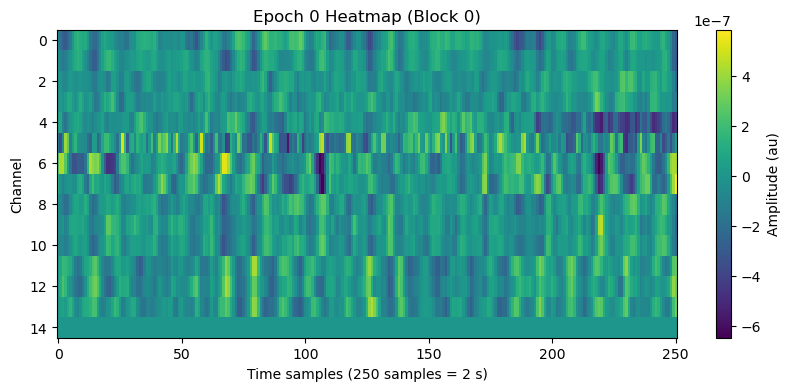

In [7]:
# Cell 2: Epoch Extraction for All Blocks
# Epoch parameters
tmin, tmax = 0.0, 2.0  # seconds
# Map annotation labels to event IDs
event_id = {f'phrase/{i}': i for i in range(1, 7)}

all_epochs = {}
for block_id, raw in raws.items():
    epochs = Epochs(
        raw, events=None, event_id=event_id,
        tmin=tmin, tmax=tmax,
        baseline=None,
        reject_by_annotation=True,
        preload=True
    )
    all_epochs[block_id] = epochs
    print(f"Block {block_id:02d}: {len(epochs)} epochs")

# Visualize the first epoch of block 18
epochs0 = all_epochs[18]
# Extract data array: shape (n_epochs, n_channels, n_times)
data = epochs0.get_data()
# Select first epoch
epoch_data = data[0]  # shape (n_channels, n_times)

# Plot as channel x time heatmap
plt.figure(figsize=(10, 4))
plt.imshow(epoch_data, aspect='auto', interpolation='none')
plt.ylabel('Channel')
plt.xlabel('Time samples (250 samples = 2 s)')
plt.title('Epoch 0 Heatmap (Block 0)')
plt.colorbar(label='Amplitude (au)')
plt.show()

## 2. Labels and Groups

In this section, we pull out the target labels for each epoch (1–6 for phrase onsets) and assign a group ID based on the originating block. We then visualize the label distribution and confirm grouping.



Block 00: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 01: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 02: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 03: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 04: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 05: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 06: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 07: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 08: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 09: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 10: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 11: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 12: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 13: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 14: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 15: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 16: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 17: label counts = [3 3 3 3 3 3] (classes 1–6)
Block 18: label counts = [3 3 3 3 3 3] (classe

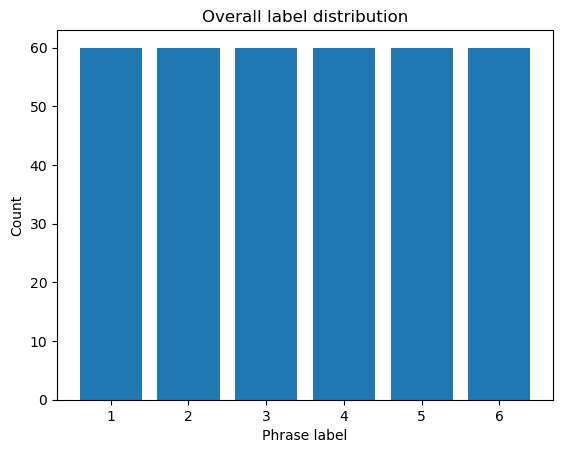

In [8]:
# Extract labels for all epochs
labels = {}
for block_id, epochs in all_epochs.items():
    # epoch.events array: columns [sample, 0, event_id]
    labels_block = epochs.events[:, 2]
    labels[block_id] = labels_block
    print(f"Block {block_id:02d}: label counts = {np.bincount(labels_block)[1:]} (classes 1–6)")

# Combine and visualize overall distribution
all_labels = np.concatenate(list(labels.values()))
unique, counts = np.unique(all_labels, return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.xlabel('Phrase label')
plt.ylabel('Count')
plt.title('Overall label distribution')
plt.show()

In [9]:
groups = {}
for block_id, epochs in all_epochs.items():
    n_epochs = len(epochs)
    groups_block = np.full(n_epochs, fill_value=block_id)
    groups[block_id] = groups_block

# Combine all group IDs and verify
all_groups = np.concatenate(list(groups.values()))
print(f"Unique group IDs: {np.unique(all_groups)}")
print(f"Group counts (epochs per block): {[(blk, len(grp)) for blk, grp in groups.items()]}" )

Unique group IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Group counts (epochs per block): [(0, 18), (1, 18), (2, 18), (3, 18), (4, 18), (5, 18), (6, 18), (7, 18), (8, 18), (9, 18), (10, 18), (11, 18), (12, 18), (13, 18), (14, 18), (15, 18), (16, 18), (17, 18), (18, 18), (19, 18)]


## 3. Split Strategy

We will use StratifiedGroupKFold to split epochs into folds that preserve label balance while keeping epochs from the same block together.

In [12]:
# Prepare arrays for splitting
n_samples = len(all_labels)
X = np.zeros((n_samples, 1))  # dummy features
y = all_labels
groups_arr = all_groups

# Create splitter
sgkf = StratifiedGroupKFold(
    n_splits=CONFIG['model']['cv_folds'],
    shuffle=True,
    random_state=42
)

# Inspect each fold
for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=groups_arr)):
    print(f"Fold {fold}: train {len(train_idx)} epochs, test {len(test_idx)} epochs")
    # label distributions
    train_counts = np.bincount(y[train_idx])[1:]
    test_counts = np.bincount(y[test_idx])[1:]
    print(f"  Train label counts: {train_counts}")
    print(f"  Test label counts:  {test_counts}")

Fold 0: train 288 epochs, test 72 epochs
  Train label counts: [48 48 48 48 48 48]
  Test label counts:  [12 12 12 12 12 12]
Fold 1: train 288 epochs, test 72 epochs
  Train label counts: [48 48 48 48 48 48]
  Test label counts:  [12 12 12 12 12 12]
Fold 2: train 288 epochs, test 72 epochs
  Train label counts: [48 48 48 48 48 48]
  Test label counts:  [12 12 12 12 12 12]
Fold 3: train 288 epochs, test 72 epochs
  Train label counts: [48 48 48 48 48 48]
  Test label counts:  [12 12 12 12 12 12]
Fold 4: train 288 epochs, test 72 epochs
  Train label counts: [48 48 48 48 48 48]
  Test label counts:  [12 12 12 12 12 12]


After running the split inspection we observe:

- Total epochs: 360 (60 per class).
- Per-fold sizes: 288 training epochs and 72 testing epochs per fold.
- Class counts:
  - Training set: 48 epochs of each label (48 × 6 = 288)
  - Test set: 12 epochs of each label (12 × 6 = 72)

This confirms that each fold is stratified (no class imbalance within splits) and that the block-based grouping ensures the same-block epochs stay together. These splits will feed into our PyTorch DataLoader for EEGNet training and evaluation.

## 4. Preprocessing

We compute per-channel normalization parameters (mean and standard deviation) on the training portion and apply z-score transformation to each epoch.

Concatenation detail: we computed these statistics over all 360 epochs from the 20 blocks (via concatenating every block’s epochs into global_data), then selected the training indices from fold 0 for normalization. This ensures consistency across folds.

In [40]:
# Cell 7: Pick only the 14 EEG channels with inst.pick
for block_id, raw in raws.items():
    raws[block_id] = raw.copy().pick(picks=CONFIG['data']['eeg_ch'])

# Verify again for block 0
data_block = raws[0]
print("Channels after picking EEG only:", data_block.ch_names)

Channels after picking EEG only: ['Fp1', 'Fp2', 'C3', 'C4', 'T7', 'T8', 'O1', 'O2', 'F3', 'F4', 'Fz', 'Pz', 'P3', 'P4']


In [34]:
# Cell 8: Re-extract epochs with only EEG channels
# Re-extract epochs for all blocks
all_epochs = {}
for block_id, raw in raws.items():
    all_epochs[block_id] = Epochs(
        raw, events=None, event_id=event_id,
        tmin=tmin, tmax=tmax,
        baseline=None,
        reject_by_annotation=True,
        preload=True
    )

# Recompute splits
n_samples = sum(len(e) for e in all_epochs.values())
X = np.zeros((n_samples, 1)); y = all_labels; groups_arr = all_groups
sgkf = StratifiedGroupKFold(n_splits=CONFIG['model']['cv_folds'], shuffle=True, random_state=42)
splits = list(sgkf.split(X, y, groups=groups_arr))

# Concatenate and compute stats on fold 0 train
global_data = np.concatenate([eps.get_data() for eps in all_epochs.values()], axis=0)
train_idx, _ = splits[0]
train_data = global_data[train_idx]
channel_means = train_data.mean(axis=(0, 2))
channel_stds  = train_data.std(axis=(0, 2))
print("Channel means:", channel_means)
print("Channel stds: ", channel_stds)

Used Annotations descriptions: [np.str_('phrase/1'), np.str_('phrase/2'), np.str_('phrase/3'), np.str_('phrase/4'), np.str_('phrase/5'), np.str_('phrase/6')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
18 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 18 events and 251 original time points ...
0 bad epochs dropped
Used Annotations descriptions: [np.str_('phrase/1'), np.str_('phrase/2'), np.str_('phrase/3'), np.str_('phrase/4'), np.str_('phrase/5'), np.str_('phrase/6')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
18 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 18 events and 251 original time points ...
0 bad epochs drop

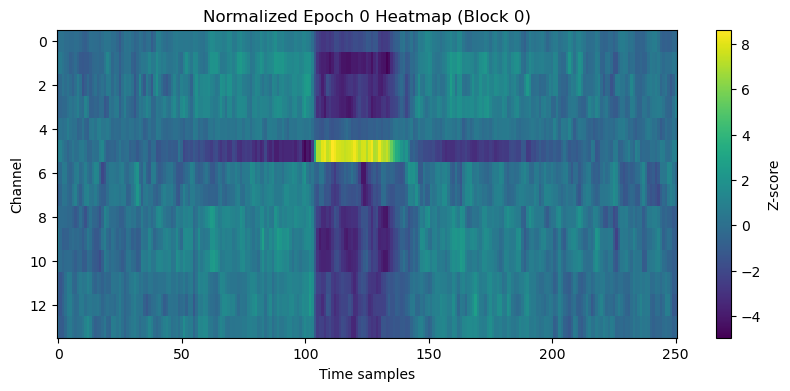

In [35]:
# Z-score example epoch
epoch = all_epochs[0].get_data()[0]
epoch_norm = (epoch - channel_means[:, None]) / channel_stds[:, None]

plt.figure(figsize=(10,4))
plt.imshow(epoch_norm, aspect='auto', interpolation='none')
plt.ylabel('Channel')
plt.xlabel('Time samples')
plt.title('Normalized Epoch 0 Heatmap (Block 0)')
plt.colorbar(label='Z-score')
plt.show()

In [41]:
# Cell 10: Detect flat epochs/channels
threshold_raw = 1e-8
flat_epochs = []
flat_channels = set()
for idx, epoch in enumerate(global_data):
    raw_stds = epoch.std(axis=1)
    if np.any(raw_stds < threshold_raw):
        flat_epochs.append(idx)
        flat_channels.update(np.where(raw_stds < threshold_raw)[0])
print(f"Flat epochs: {len(flat_epochs)} / {len(global_data)}")
print(f"Flat channel indices: {sorted(flat_channels)}")

Flat epochs: 0 / 360
Flat channel indices: []


## 5. Class Imbalance

We compute class frequencies across all epochs and derive inverse-frequency weights to use in the loss function, ensuring the minority classes receive higher penalty.

Class counts: {np.int64(1): 60, np.int64(2): 60, np.int64(3): 60, np.int64(4): 60, np.int64(5): 60, np.int64(6): 60}
Class weights: {np.int64(1): 1.0, np.int64(2): 1.0, np.int64(3): 1.0, np.int64(4): 1.0, np.int64(5): 1.0, np.int64(6): 1.0}
Weights tensor: tensor([1., 1., 1., 1., 1., 1.])


Text(0.5, 1.0, 'Inverse-Frequency Class Weights')

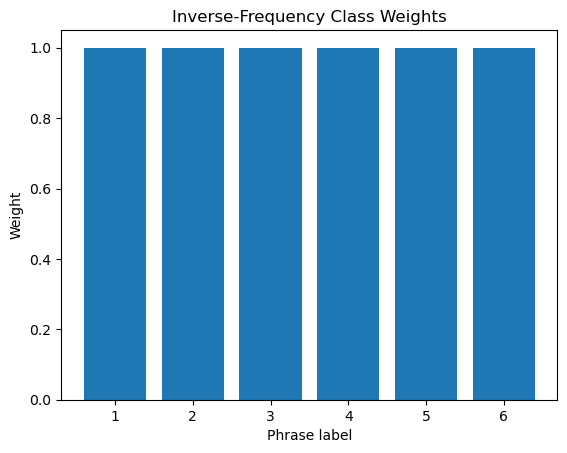

In [42]:
# Cell 11: Class imbalance analysis
# Count each class in all_labels
total_epochs = len(all_labels)
class_counts = Counter(all_labels)
print("Class counts:", dict(class_counts))

# Compute inverse-frequency weights: weight_c = N_total / (n_classes * count_c)
n_classes = len(class_counts)
class_weights = {cls: total_epochs / (n_classes * count) for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# Convert to torch tensor ordered by class label
sorted_labels = sorted(class_weights.keys())
weights_tensor = torch.tensor([class_weights[cls] for cls in sorted_labels], dtype=torch.float)
print("Weights tensor:", weights_tensor)

# Visualize weights
plt.figure()
plt.bar(sorted_labels, [class_weights[cls] for cls in sorted_labels])
plt.xlabel('Phrase label')
plt.ylabel('Weight')
plt.title('Inverse-Frequency Class Weights')

## 6. EEGNet Architecture & Training

Define the EEGNet model in PyTorch, instantiate it, perform a forward pass on a dummy batch, and set up the training loop skeleton.

In [63]:
# Cell 12: EEGNet model definition
import torch
import torch.nn as nn
import math

def create_eegnet(n_channels, n_times, n_classes):
    class EEGNet(nn.Module):
        def __init__(self):
            super(EEGNet, self).__init__()
            # Temporal convolution
            self.temporal = nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False)
            # Depthwise spatial convolution
            self.depthwise = nn.Conv2d(16, 16, (n_channels, 1), groups=16, bias=False)
            # First pooling and batch norm
            self.pool1 = nn.AvgPool2d((1, 4))
            self.bn1   = nn.BatchNorm2d(16)
            # Separable convolution block
            self.sep = nn.Sequential(
                nn.Conv2d(16, 32, (1, 16), padding=(0, 8), bias=False),
                nn.Conv2d(32, 32, (1, 1), bias=False),
                nn.AvgPool2d((1, 8)),
                nn.BatchNorm2d(32)
            )
            # Classification layer using LazyLinear
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(0.5),
                nn.LazyLinear(n_classes)
            )

        def forward(self, x):
            x = self.temporal(x)
            x = self.depthwise(x)
            x = self.pool1(x)
            x = self.bn1(x)
            x = self.sep(x)
            return self.classifier(x)

    return EEGNet()

# Instantiate and test model
n_channels = len(CONFIG['data']['eeg_ch'])
# Determine time points from extracted epochs (use actual data length)
n_times = all_epochs[0].get_data().shape[2]  # e.g., 251 samples per epoch
n_classes = len(sorted_labels)
model = create_eegnet(n_channels, n_times, n_classes)
print(model)

EEGNet(
  (temporal): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (depthwise): Conv2d(16, 16, kernel_size=(14, 1), stride=(1, 1), groups=16, bias=False)
  (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sep): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): LazyLinear(in_features=0, out_features=6, bias=True)
  )
)


In [71]:
# Cell 13: Test forward pass on dummy data
batch_size = 8
# Dummy input shape: (batch, 1, n_channels, n_times)
dummy_input = torch.randn(batch_size, 1, n_channels, n_times)
output = model(dummy_input)
print(f"Output shape: {output.shape} (should be {batch_size} x {n_classes})")

Output shape: torch.Size([8, 6]) (should be 8 x 6)


In [65]:
# Cell 14: Setup optimizer, loss, and one training step example
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Example training step
def train_step(x, y):
    model.train()
    optimizer.zero_grad()
    preds = model(x)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Test train_step with dummy labels
dummy_labels = torch.randint(0, n_classes, (batch_size,))
loss_val = train_step(dummy_input, dummy_labels)
print(f"Dummy training loss: {loss_val:.4f}")

Dummy training loss: 2.1769


## 7. Dataset & DataLoader

We have loaded raw FIFs and extracted epochs, but now need to wrap these into a PyTorch Dataset and create DataLoaders for training and evaluation.

In [66]:
# Cell 15: Custom Dataset for EEG epochs
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, epochs_dict, labels_dict, transform=None):
        # epochs_dict: {block_id: mne.Epochs}
        # labels_dict: {block_id: np.array of labels}
        self.data = []
        self.labels = []
        for blk, epochs in epochs_dict.items():
            data = epochs.get_data()  # (n_epochs, n_ch, n_times)
            labs = labels_dict[blk]
            for i in range(data.shape[0]):
                self.data.append(data[i])
                self.labels.append(labs[i] - 1)  # zero-indexed for PyTorch
        self.data = np.stack(self.data)  # (N, n_ch, n_times)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        # add channel dimension for Conv2d
        x = torch.tensor(x, dtype=torch.float).unsqueeze(0)
        return x, y

In [67]:
# Cell 16: Instantiate DataLoaders for fold 0
# Get train/test indices from splits
train_idx, test_idx = splits[0]

# Create full dataset
dataset = EEGDataset(all_epochs, labels, transform=lambda x: (x - channel_means[:, None]) / channel_stds[:, None])

# Subset using indices
target_sampler = torch.utils.data.SubsetRandomSampler
dataloader_train = DataLoader(dataset, batch_size=32, sampler=target_sampler(train_idx))
dataloader_test  = DataLoader(dataset, batch_size=32, sampler=target_sampler(test_idx))

# Quick sanity check: fetch one batch
for X_batch, y_batch in dataloader_train:
    print(f"Batch X shape: {X_batch.shape}, y shape: {y_batch.shape}")
    break

Batch X shape: torch.Size([32, 1, 14, 251]), y shape: torch.Size([32])


## 8. Training and Validation Loop

We now train EEGNet on fold 0’s training set and validate on the held-out portion, logging training loss and balanced accuracy on validation each epoch. Early stopping and learning-rate scheduling help prevent overfitting.

In [72]:
# Cell 17: Train/Validation Loop
import torch
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import SubsetRandomSampler, DataLoader

# Ensure DataLoaders are defined (re-run Cell 16 if not)
try:
    dataloader_val
except NameError:
    sampler_train = SubsetRandomSampler(train_idx)
    sampler_val   = SubsetRandomSampler(test_idx)
    dataloader_train = DataLoader(dataset, batch_size=32, sampler=sampler_train)
    dataloader_val   = DataLoader(dataset, batch_size=32, sampler=sampler_val)

n_epochs = 30
patience = 5
best_val = 0.0
counter = 0

# Scheduler to reduce LR if no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history = {'train_loss': [], 'val_bal_acc': []}

for epoch in range(1, n_epochs+1):
    # ----- Training -----
    model.train()
    running_loss = []
    for X, y in dataloader_train:
        loss = train_step(X, y)
        running_loss.append(loss)
    avg_train_loss = np.mean(running_loss)
    history['train_loss'].append(avg_train_loss)

    # ----- Validation -----
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for X_val, y_val in dataloader_val:
            logits = model(X_val)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_val.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    val_bal_acc = balanced_accuracy_score(all_true, all_preds)
    history['val_bal_acc'].append(val_bal_acc)

    # Scheduler step
    scheduler.step(val_bal_acc)

    print(f"Epoch {epoch}/{n_epochs}  Train Loss: {avg_train_loss:.4f}  Val Bal Acc: {val_bal_acc:.4f}")

    # Early stopping
    if val_bal_acc > best_val:
        best_val = val_bal_acc
        counter = 0
        torch.save(model.state_dict(), CONFIG['paths']['deep_dir'] / 'best_model_fold0.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping: no improvement for {patience} epochs")
            break

print(f"Training complete. Best Val balanced accuracy: {best_val:.4f}")

Epoch 1/30  Train Loss: 2.0577  Val Bal Acc: 0.1806
Epoch 2/30  Train Loss: 2.0122  Val Bal Acc: 0.1944
Epoch 3/30  Train Loss: 2.0186  Val Bal Acc: 0.2083
Epoch 4/30  Train Loss: 2.0409  Val Bal Acc: 0.2222
Epoch 5/30  Train Loss: 2.0000  Val Bal Acc: 0.2222
Epoch 6/30  Train Loss: 2.0836  Val Bal Acc: 0.2083
Epoch 7/30  Train Loss: 1.9921  Val Bal Acc: 0.2083
Epoch 8/30  Train Loss: 2.0515  Val Bal Acc: 0.2083
Epoch 9/30  Train Loss: 1.9433  Val Bal Acc: 0.2083
Early stopping: no improvement for 5 epochs
Training complete. Best Val balanced accuracy: 0.2222


## 9. Confusion Matrix

After training, generate and visualize a confusion matrix on the validation set of fold 0 to identify which phrase classes are most frequently confused.

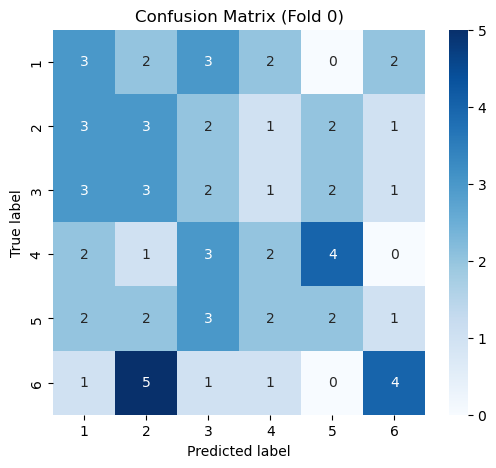

In [73]:
# Cell 18: Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load the best model weights
model.load_state_dict(torch.load(CONFIG['paths']['deep_dir'] / 'best_model_fold0.pth'))
model.eval()

# Collect predictions and true labels on validation set
all_preds, all_true = [], []
with torch.no_grad():
    for X_val, y_val in dataloader_val:
        logits = model(X_val)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_val.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds, labels=list(range(n_classes)))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Fold 0)')
plt.show()